# Analyzing Client Behavior and Determining which prepaid plan is more profitable
We are performing analysis for the telecom operator Megaline. The company offers its clients two prepaid plans, Surf and Ultimate. The commercial department wants to know which of the plans brings in more revenue in order to adjust the advertising budget. We will study the data to analyze client behavior

# Table of Contents

1. [General Information](#step1)
2. [Data Preprocessing](#step2)
3. [Analysis](#step3)
4. [Hypothesis Testing](#step4)
5. [Overall Conclusion](#step5)

## General Information <a name='step1'></a>

We will start by importing the necessary libraries we will need for this project

In [1]:
from scipy import stats as st #for probability and statistics calculations
import pandas as pd #for dataframe manipulation
import matplotlib.pyplot as plt #for graph plotting and display
import numpy as np #for advanced mathematical operations
import nltk #for string/text manipulation

Now we will put all the datasets we were given into dataframes

In [2]:
calls = pd.read_csv('/datasets/megaline_calls.csv')
#reads the megaline_calls.csv file and converts it into a dataframe called 'calls'

internet = pd.read_csv('/datasets/megaline_internet.csv')
#reads the megaline_internet.csv file and converts it into a dataframe called 'internet'

messages = pd.read_csv('/datasets/megaline_messages.csv')
#reads the megaline_messages.csv file and converts it into a dataframe called 'messages'

plans = pd.read_csv('/datasets/megaline_plans.csv')
#reads the megaline_plans.csv file and converts it into a dataframe called 'plans'

users = pd.read_csv('/datasets/megaline_users.csv')
#reads the megaline_users.csv file and converts it into a dataframe called 'users'

The 'calls' table stores information about the calls made by each user

In [3]:
calls.info(verbose=True) #gives generfal information about calls table

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137735 entries, 0 to 137734
Data columns (total 4 columns):
id           137735 non-null object
user_id      137735 non-null int64
call_date    137735 non-null object
duration     137735 non-null float64
dtypes: float64(1), int64(1), object(2)
memory usage: 4.2+ MB


Our first order of business with the calls table will be to convert the 'call_date' column into date-time type, then we will also round up the duration.

In [4]:
calls.head() #displays the first 5 rows of the table

,id,user_id,call_date,duration
0,1000_93,1000,2018-12-27,8.52
1,1000_145,1000,2018-12-27,13.66
2,1000_247,1000,2018-12-27,14.48
3,1000_309,1000,2018-12-28,5.76
4,1000_380,1000,2018-12-30,4.22


The 'internet' table stores information about the volume of data used by each user

In [5]:
internet.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104825 entries, 0 to 104824
Data columns (total 4 columns):
id              104825 non-null object
user_id         104825 non-null int64
session_date    104825 non-null object
mb_used         104825 non-null float64
dtypes: float64(1), int64(1), object(2)
memory usage: 3.2+ MB


We need to convert 'session_date' values into date-time type and also convert the 'mb_used' values to Gigabytes and then round them up 

In [6]:
internet.head()

,id,user_id,session_date,mb_used
0,1000_13,1000,2018-12-29,89.86
1,1000_204,1000,2018-12-31,0.00
2,1000_379,1000,2018-12-28,660.40
3,1000_413,1000,2018-12-26,270.99
4,1000_442,1000,2018-12-27,880.22


The 'messages' table stores information about the messages sent by each user

In [7]:
messages.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76051 entries, 0 to 76050
Data columns (total 3 columns):
id              76051 non-null object
user_id         76051 non-null int64
message_date    76051 non-null object
dtypes: int64(1), object(2)
memory usage: 1.7+ MB


The values of the 'message_date' column needs to be converted to date-time type.

In [8]:
messages.head()

,id,user_id,message_date
0,1000_125,1000,2018-12-27
1,1000_160,1000,2018-12-31
2,1000_223,1000,2018-12-31
3,1000_251,1000,2018-12-27
4,1000_255,1000,2018-12-26


The 'plans' table stores information about the plans offered by Megaline

In [9]:
plans.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
messages_included        2 non-null int64
mb_per_month_included    2 non-null int64
minutes_included         2 non-null int64
usd_monthly_pay          2 non-null int64
usd_per_gb               2 non-null int64
usd_per_message          2 non-null float64
usd_per_minute           2 non-null float64
plan_name                2 non-null object
dtypes: float64(2), int64(5), object(1)
memory usage: 256.0+ bytes


In [10]:
plans.head()

,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name
0,50,15360,500,20,10,0.03,0.03,surf
1,1000,30720,3000,70,7,0.01,0.01,ultimate


The 'users' table stores information about the users

In [11]:
users.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
user_id       500 non-null int64
first_name    500 non-null object
last_name     500 non-null object
age           500 non-null int64
city          500 non-null object
reg_date      500 non-null object
plan          500 non-null object
churn_date    34 non-null object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


We notice missing values in the 'churn_date' column. However, the 'churn_date' is the date when users decided to end their subscription so if it's empty, it means the subscription is ongoing. In this case, we will leave it as is.

In [12]:
users.head()

,user_id,first_name,last_name,age,city,reg_date,plan,churn_date
0,1000,Anamaria,Bauer,45,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-12-24,ultimate,NaN
1,1001,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,NaN
2,1002,Carlee,Hoffman,36,"Las Vegas-Henderson-Paradise, NV MSA",2018-10-21,surf,NaN
3,1003,Reynaldo,Jenkins,52,"Tulsa, OK MSA",2018-01-28,surf,NaN
4,1004,Leonila,Thompson,40,"Seattle-Tacoma-Bellevue, WA MSA",2018-05-23,surf,NaN


- **Conclusion**

We have looked at the data sets we were given and found issues that need to be addressed

## Data Preprocessing <a name='step2'></a>

### The 'calls' table

First, we will round up the values in the 'duration' column. For this we will apply the 'np.ceil' method to the column

In [13]:
calls['duration'] = calls['duration'].apply(np.ceil).astype('int')
#this applies the np.ceil method  to the column to round up its values and then converts them to integers

calls.info(verbose=True) #general info about 'calls' table after change

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137735 entries, 0 to 137734
Data columns (total 4 columns):
id           137735 non-null object
user_id      137735 non-null int64
call_date    137735 non-null object
duration     137735 non-null int64
dtypes: int64(2), object(2)
memory usage: 4.2+ MB


Now, we will convert the values of the 'call_date' column to date-time type. We need to use the 'pd.to_datetime()' method which takes 2 arguments: the column, and the format. As for the format, we saw in the table that the dates had the format 'yyyy-mm-dd'. So the format parameter will be set to '%Y-%m-%d' so as to reflect the existing format in the table.

In [14]:
calls['call_date'] = pd.to_datetime(calls['call_date'], format='%Y-%m-%d')
#this converts the 'call_date' values to date-time type using the existing format

calls.info(verbose=True) #general info about 'calls' table after change

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137735 entries, 0 to 137734
Data columns (total 4 columns):
id           137735 non-null object
user_id      137735 non-null int64
call_date    137735 non-null datetime64[ns]
duration     137735 non-null int64
dtypes: datetime64[ns](1), int64(2), object(1)
memory usage: 4.2+ MB


Let us now add a column which tells us the month when each call was made. We can extract the month name from the date using the 'dt.month_name()' method. We will call our new column 'call_month'

In [15]:
calls['call_month'] = calls['call_date'].dt.month_name()
#this extracts the month's name from the call_date column and saves it to our new 'call_month' column

calls.head() #first 5 rows of the 'calls' table after the change

,id,user_id,call_date,duration,call_month
0,1000_93,1000,2018-12-27,9,December
1,1000_145,1000,2018-12-27,14,December
2,1000_247,1000,2018-12-27,15,December
3,1000_309,1000,2018-12-28,6,December
4,1000_380,1000,2018-12-30,5,December


### The 'internet' table

First, let us convert the values in the 'mb_used' column from megabytes to gigabytes (1GB = 1024MB). We can then round up those values ('np.ceil') and change the name of the column ('rename').

In [16]:
internet['mb_used'] = internet['mb_used']/1024
#divides the values in the column by 1024 so as to convert them to Gigabytes

internet['mb_used'] = internet['mb_used'].apply(np.ceil).astype('int')
#this rounds up the values and converts them to integers

internet = internet.rename(columns={'mb_used': 'gb_used'})
#this renames the column from mb_used to gb_used

internet.info(verbose=True) #displays general information after the changes

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104825 entries, 0 to 104824
Data columns (total 4 columns):
id              104825 non-null object
user_id         104825 non-null int64
session_date    104825 non-null object
gb_used         104825 non-null int64
dtypes: int64(2), object(2)
memory usage: 3.2+ MB


Now, let us convert the 'session_date' column to date-time type. Same drill as before: 'pd.to_datetime' method with format='%Y-%m-%d' parameter

In [17]:
internet['session_date'] = pd.to_datetime(internet['session_date'], format='%Y-%m-%d')
#this converts the session_date column to the date-time type with the appropriate format

internet.info(verbose=True) #general info after changes 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104825 entries, 0 to 104824
Data columns (total 4 columns):
id              104825 non-null object
user_id         104825 non-null int64
session_date    104825 non-null datetime64[ns]
gb_used         104825 non-null int64
dtypes: datetime64[ns](1), int64(2), object(1)
memory usage: 3.2+ MB


We will now create a 'session_month' column that extracts the month name from the 'session_date' column

In [18]:
internet['session_month'] = internet['session_date'].dt.month_name()
#extracts the month name from the session_date column and saves it to our new session_month column

internet.head() #first 5 rows of the table after changes

,id,user_id,session_date,gb_used,session_month
0,1000_13,1000,2018-12-29,1,December
1,1000_204,1000,2018-12-31,0,December
2,1000_379,1000,2018-12-28,1,December
3,1000_413,1000,2018-12-26,1,December
4,1000_442,1000,2018-12-27,1,December


### The 'messages' table

First, we will convert the 'message_date' values to date-time type. Same as before

In [19]:
messages['message_date'] = pd.to_datetime(messages['message_date'], format='%Y-%m-%d')
#converts message_date values to date-time type with the appropriate format

messages.info(verbose=True) #general info after changes

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76051 entries, 0 to 76050
Data columns (total 3 columns):
id              76051 non-null object
user_id         76051 non-null int64
message_date    76051 non-null datetime64[ns]
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 1.7+ MB


Now, we will create a new column called 'message_month' that extracts the month name from the 'message_date'

In [20]:
messages['message_month'] = messages['message_date'].dt.month_name()
#extracts the month name from 'message_date' and saves it to our new message_month column

messages.head() #dataframe's general info 

,id,user_id,message_date,message_month
0,1000_125,1000,2018-12-27,December
1,1000_160,1000,2018-12-31,December
2,1000_223,1000,2018-12-31,December
3,1000_251,1000,2018-12-27,December
4,1000_255,1000,2018-12-26,December


### The 'plans' table

Here, let us convert the 'mb_per_month_included' to gigabytes (dividing by 1024) and rename the column 'gb_per_month_included'

In [21]:
plans['mb_per_month_included'] = plans['mb_per_month_included']/1024
#converts the values to gigabytes by dividing by 1024

plans = plans.rename(columns={'mb_per_month_included':'gb_per_month_included'})
#renames the 'mb_per_month_included' column to 'gb_per_month_included'

plans.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
messages_included        2 non-null int64
gb_per_month_included    2 non-null float64
minutes_included         2 non-null int64
usd_monthly_pay          2 non-null int64
usd_per_gb               2 non-null int64
usd_per_message          2 non-null float64
usd_per_minute           2 non-null float64
plan_name                2 non-null object
dtypes: float64(3), int64(4), object(1)
memory usage: 256.0+ bytes


### The 'users' table

Here, all we need to do is convert the 'plan' column to category type

In [22]:
users['plan'] = users['plan'].astype('category')
#converts the 'plan' column to category type

users.info(verbose=True) #general info about the users table

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
user_id       500 non-null int64
first_name    500 non-null object
last_name     500 non-null object
age           500 non-null int64
city          500 non-null object
reg_date      500 non-null object
plan          500 non-null category
churn_date    34 non-null object
dtypes: category(1), int64(2), object(5)
memory usage: 28.1+ KB


### Getting all our calculations and the data we need for analysis into one table

So far, all our data is in different tables. It will be helpful to have all the data we need to analyze in one table. So we will create a new table called 'user_stats' and start it off with some of the columns in the 'users' table.

In [23]:
user_stats = users[['user_id', 'first_name', 'last_name', 'city', 'plan']]
#creates a user_stats table which contains columns from the 'users' table: 'user_id', 'first_name',
#'last_name', 'city', and 'plan'

user_stats.head() #general info about our new table

,user_id,first_name,last_name,city,plan
0,1000,Anamaria,Bauer,"Atlanta-Sandy Springs-Roswell, GA MSA",ultimate
1,1001,Mickey,Wilkerson,"Seattle-Tacoma-Bellevue, WA MSA",surf
2,1002,Carlee,Hoffman,"Las Vegas-Henderson-Paradise, NV MSA",surf
3,1003,Reynaldo,Jenkins,"Tulsa, OK MSA",surf
4,1004,Leonila,Thompson,"Seattle-Tacoma-Bellevue, WA MSA",surf


One very important thing to note is that across all tables (except the 'plans' table) users are identifiable by the 'user_id' column. This will prove helpful for our calculations. Now let's add some columns

#### Number of calls made per month

Here, we will write a function called 'calls_per_month'. This function will take a user_id as argument. For each user_id, it will create a slice in the 'calls' table. It will then calculate the number of calls (by getting the length of the slice) and divide it by the number of different months present in the slice and returns the result if the number of months is greater than zero. Then this function will be applied to the 'user_id' column of our new 'user_stats' table. If there are any empty cells in our new columns for user_id's whose number of months was zero, we can fill those with zero.

In [24]:
def calls_per_month(user_id): 
#creates a function called 'calls_per_month' which takes as argument user_id

    user_calls_slice = calls.query('user_id == @user_id')
#creates a slice for the user_id in the calls table

    number_of_calls = len(user_calls_slice)
#gets the number of calls by calculating the number of rows the slice has

    months = len(user_calls_slice['call_month'].unique())
#gets the number of different 'call_month' values in the slice

    if months > 0:
#if the number of months is greater than zero
        
        cpm = number_of_calls/months
#creates a variable cpm that stores the result of the number of calls divided by the number of different
#months

        return cpm
#returns the value of the cpm variable


user_stats['calls_per_month'] = user_stats['user_id'].apply(calls_per_month)
#applies the calls_per_month fuction to the user_id column of our user_stats table and save the results to 
#our new 'calls_per_month' column 

user_stats['calls_per_month'] = user_stats['calls_per_month'].fillna(0)
#fills the empty cells with zero

user_stats.info(verbose=True) #general info about the user_stats table

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 6 columns):
user_id            500 non-null int64
first_name         500 non-null object
last_name          500 non-null object
city               500 non-null object
plan               500 non-null category
calls_per_month    500 non-null float64
dtypes: category(1), float64(1), int64(1), object(3)
memory usage: 20.2+ KB


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


#### Number of minutes per month

Here, we will define a function called 'mins_per_month' that will take the user_id as argument. A slice will be created in the 'calls' table using that user_id. Then we will divide the number of minutes (by adding up all the values in the 'duration' column) by the number of different months if the number of different months is greater than zero. Then we apply this function to the 'user_id' column of our user_stats table and save the results to our new 'mins_per_month' column. Then for the rest of the empty values (if any), we fill them with zero. 

In [25]:
def mins_per_month(user_id):
#creates a function called 'mins_per_month' which takes user_id as argument

    user_mins_slice = calls.query('user_id == @user_id')
#creates a slice in the calls table using the user_id

    minutes = user_mins_slice['duration'].sum()
#calculates the number of minutes by adding up all the duration column values

    months = len(user_mins_slice['call_month'].unique())
#calculates the number of different months

    if months > 0:
#if the number of months is greater than zero

        mpm = minutes/months
#creates a variable called mpm that divides the sum of all minutes by the number of different months

        return mpm
#returns the value of mpm

    
user_stats['mins_per_month'] = user_stats['user_id'].apply(mins_per_month)
#applies the 'mins_per_month' function to the user_id column of our user_stats table and saves the
#results to our new 'mins_per_month' table

user_stats['mins_per_month'] = user_stats['mins_per_month'].fillna(0)
#returns 0 for all rows where there are missing values

user_stats.head() #first 5 rows of our user_stats

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,user_id,first_name,last_name,city,plan,calls_per_month,mins_per_month
0,1000,Anamaria,Bauer,"Atlanta-Sandy Springs-Roswell, GA MSA",ultimate,16.000000,124.000000
1,1001,Mickey,Wilkerson,"Seattle-Tacoma-Bellevue, WA MSA",surf,52.200000,345.600000
2,1002,Carlee,Hoffman,"Las Vegas-Henderson-Paradise, NV MSA",surf,37.666667,276.333333
3,1003,Reynaldo,Jenkins,"Tulsa, OK MSA",surf,149.000000,1104.000000
4,1004,Leonila,Thompson,"Seattle-Tacoma-Bellevue, WA MSA",surf,46.250000,346.500000


In [26]:
user_stats['mins_per_month'].isna().sum()

0

#### Number of text messages sent per month

The process will be similar except here, we will be creating a slice in the 'messages' table and we will be dividing the number of text by the number of months, and our new column is 'messages_per_month'

In [27]:
def messages_per_month(user_id):
    user_messages_slice = messages.query('user_id == @user_id')
    number_of_mess = len(user_messages_slice)
    months = len(user_messages_slice['message_month'].unique())
    
    if months > 0:
        mess_pm = number_of_mess/months
        return mess_pm
        
    
    
user_stats['messages_per_month'] = user_stats['user_id'].apply(messages_per_month)
user_stats['messages_per_month'] = user_stats['messages_per_month'].fillna(0)

user_stats.head()

,user_id,first_name,last_name,city,plan,calls_per_month,mins_per_month,messages_per_month
0,1000,Anamaria,Bauer,"Atlanta-Sandy Springs-Roswell, GA MSA",ultimate,16.000000,124.000000,11.000000
1,1001,Mickey,Wilkerson,"Seattle-Tacoma-Bellevue, WA MSA",surf,52.200000,345.600000,41.400000
2,1002,Carlee,Hoffman,"Las Vegas-Henderson-Paradise, NV MSA",surf,37.666667,276.333333,29.333333
3,1003,Reynaldo,Jenkins,"Tulsa, OK MSA",surf,149.000000,1104.000000,50.000000
4,1004,Leonila,Thompson,"Seattle-Tacoma-Bellevue, WA MSA",surf,46.250000,346.500000,22.125000


In [28]:
user_stats['messages_per_month'].isna().sum()

0

#### Volume of data used per month

Same drill, except we will be creating a slice in the 'internet' table, and we will be dividing the sum of all the 'gb_used' by the number of different session months. Our new column in the user_stats table will be 'gb_per_month'

In [29]:
def gb_per_month(user_id):
    user_gb_slice = internet.query('user_id == @user_id')
    gb_amount = user_gb_slice['gb_used'].sum()
    months = len(user_gb_slice['session_month'].unique())
    if months > 0:
        vpm = gb_amount/months
        return vpm
    
user_stats['gb_per_month'] = user_stats['user_id'].apply(gb_per_month)
user_stats['gb_per_month'] = user_stats['gb_per_month'].fillna(0)
user_stats.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 9 columns):
user_id               500 non-null int64
first_name            500 non-null object
last_name             500 non-null object
city                  500 non-null object
plan                  500 non-null category
calls_per_month       500 non-null float64
mins_per_month        500 non-null float64
messages_per_month    500 non-null float64
gb_per_month          500 non-null float64
dtypes: category(1), float64(4), int64(1), object(3)
memory usage: 32.0+ KB


In [30]:
user_stats['gb_per_month'].isna().sum()

0

#### Monthly profit

This will be a little different. Here, we will be dealing with 4 rows which are already in our user_stats table: 'mins_per_month', 'messages_per_month', 'gb_per_month', and 'plan'. In this case, our defined function will take the table row as its argument and on each row, it will check whether the value of the 'plan' column (whether it is 'surf' or 'ultimate') and perform the appropriate calculation. In this case, the function will be applied to the whole table. 

In [31]:
def monthly_profit(row): #creates a function called monthly_profit that takes a table row as argument
    mins_diff = 0 #creates a variable called mins_diff and sets it to zero
    mess_diff = 0 #creates a variable called mess_diff and sets it to zero
    gb_diff = 0 #creates a variable called gb_diff and sets it to zero
    plan = row['plan'] 
    #creates a variable called plan that takes the value of the 'plan' column for the row in question
    
    #conditional statement
    if plan == 'surf': #if value of the 'plan' variable is 'surf'
        
        #conditional statement
        if row['mins_per_month'] > 500: 
        #if the value of the 'mins_per_month' column in the row is greater than 500
        
            mins_diff = row['mins_per_month'] - 500
            #mins_diff will take the value of the 'mins_per_month' column minus the package limit for surf
            
        #conditional statement
        if row['messages_per_month'] > 50:
        #if the value of the 'messages_per_month' column in the row is greater than 50
        
            mess_diff = row['messages_per_month'] - 50
            #mess_diff becomes the difference between the value at the 'messages_per_month' column and
            #the package limit for surf
            
        #conditional statement
        if row['gb_per_month'] > 15: #if the value of the 'gb_per_month' column is greater than 15
            gb_diff = row['gb_per_month'] - 15
            #gb_diff becomes the difference between the value at the 'gb_per_month' coulmn and the
            #package limit for surf
            
        profit = (mins_diff * .03) + (mess_diff * .03) + (gb_diff * 10)
        #performs the appropriate profit calculation for the surf plan and saves it to a variable called
        #profit
    
    #conditional statement 
    if plan == 'ultimate': #if the value of the plan variable is 'ultimate'
        
        #conditional statement 
        if row['mins_per_month'] > 3000:
        #if the value of the 'mins_per_month' column in the row is greater than 3000
            
            mins_diff = row['mins_per_month'] - 3000
            #mins_diff will take the value of the 'mins_per_month' column minus the package limit for
            #ultimate
            
        #conditional statement    
        if row['messages_per_month'] > 1000:
        #if the value of the 'messages_per_month' column in the row is greater than 1000
            
            mess_diff = row['messages_per_month'] - 1000
            #mess_diff becomes the difference between the value at the 'messages_per_month' column and
            #the package limit for ultimate
            
        #conditional statement
        if row['gb_per_month'] > 30: #if the value of the 'gb_per_month' column is greater than 30
            gb_diff = row['gb_per_month'] - 30
            #gb_diff becomes the difference between the value at the 'gb_per_month' coulmn and the
            #package limit for ultimate
            
        profit = (mins_diff * .01) + (mess_diff * .01) + (gb_diff * 7)
        #performs the appropriate profit calculation for the ultimate plan and saves it to a variable called
        #profit
        
    return profit #returns the value of the profit variable

user_stats['monthly_profit'] = user_stats.apply(monthly_profit, axis=1)
#applies the monthly_profit function to the user_stats table, appending each row with its result and the 
#new column will be called monthly_profit

user_stats.head() #First 5 rows of our user_stats table after changes

,user_id,first_name,last_name,city,plan,calls_per_month,mins_per_month,messages_per_month,gb_per_month,monthly_profit
0,1000,Anamaria,Bauer,"Atlanta-Sandy Springs-Roswell, GA MSA",ultimate,16.000000,124.000000,11.000000,4.000000,0.000000
1,1001,Mickey,Wilkerson,"Seattle-Tacoma-Bellevue, WA MSA",surf,52.200000,345.600000,41.400000,43.200000,282.000000
2,1002,Carlee,Hoffman,"Las Vegas-Henderson-Paradise, NV MSA",surf,37.666667,276.333333,29.333333,32.333333,173.333333
3,1003,Reynaldo,Jenkins,"Tulsa, OK MSA",surf,149.000000,1104.000000,50.000000,53.000000,398.120000
4,1004,Leonila,Thompson,"Seattle-Tacoma-Bellevue, WA MSA",surf,46.250000,346.500000,22.125000,49.875000,348.750000


In [32]:
user_stats['monthly_profit'].isna().sum()

0

#### Region

Down the line, we will need to compare data in the NY-NJ area against other areas. So we can create another column in our user_stats table called 'region'. We will surely have to extract the information from the 'city' column. Let us take a look at the unique values in the 'city' column

In [33]:
user_stats['city'].unique()

array(['Atlanta-Sandy Springs-Roswell, GA MSA',
       'Seattle-Tacoma-Bellevue, WA MSA',
       'Las Vegas-Henderson-Paradise, NV MSA', 'Tulsa, OK MSA',
       'Dallas-Fort Worth-Arlington, TX MSA',
       'San Francisco-Oakland-Berkeley, CA MSA',
       'Grand Rapids-Kentwood, MI MSA',
       'Orlando-Kissimmee-Sanford, FL MSA',
       'San Jose-Sunnyvale-Santa Clara, CA MSA',
       'Cleveland-Elyria, OH MSA',
       'Chicago-Naperville-Elgin, IL-IN-WI MSA', 'Knoxville, TN MSA',
       'New York-Newark-Jersey City, NY-NJ-PA MSA', 'Pittsburgh, PA MSA',
       'Fresno, CA MSA',
       'Washington-Arlington-Alexandria, DC-VA-MD-WV MSA',
       'Indianapolis-Carmel-Anderson, IN MSA', 'Jacksonville, FL MSA',
       'Los Angeles-Long Beach-Anaheim, CA MSA',
       'Omaha-Council Bluffs, NE-IA MSA',
       'Houston-The Woodlands-Sugar Land, TX MSA',
       'Philadelphia-Camden-Wilmington, PA-NJ-DE-MD MSA',
       'Tampa-St. Petersburg-Clearwater, FL MSA',
       'Birmingham-Hoover, AL MSA'

We can see that sometimes we can see that a specific state is referenced. Other times, we are given a multi-state area, written by hyphenating the states concerned. So in our case, we need to include the specific states that are NY and NJ, and any multi-state area that has 'NY-NJ'. We will have to split the string, separating by commas. In this case, the multi-area states will stay as one with their hyphens. Then we'll loop through the fragments created and use a conditional statement for comparison

In [34]:
def region(city):
#creates a function called region that takes the city as argument

    no_commas = city.split(",")
#creates a list fragments from the string value (by splitting the string at the commas). We call the list
#no_commas

    for entry in no_commas:
#loops through the fragments

#conditional statement
        if ('NY-NJ' in entry)|(entry == 'NY')|(entry == 'NJ'):
#if the string 'NY-NJ' is part of the fragment, or one of the fragments equals 'NY', or one of the fragments
#equals 'NJ'

            return 'ny-nj' #Returns the string 'ny-nj'

        
user_stats['region'] = user_stats['city'].apply(region)
#applies the region function to the city column and stores the results in the new column called region

user_stats['region'] = user_stats['region'].fillna('other')
#this fills the other columns that did not fulfill the condition  with the string 'other'

user_stats['region'] = user_stats['region'].astype('category')
#this converts the values in the region column to the category type

user_stats['region'].value_counts() #gives us the differnt values of the region column and their counts

other    420
ny-nj     80
Name: region, dtype: int64

In [35]:
user_stats.head() #first 5 rows of our user_stats table

,user_id,first_name,last_name,city,plan,calls_per_month,mins_per_month,messages_per_month,gb_per_month,monthly_profit,region
0,1000,Anamaria,Bauer,"Atlanta-Sandy Springs-Roswell, GA MSA",ultimate,16.000000,124.000000,11.000000,4.000000,0.000000,other
1,1001,Mickey,Wilkerson,"Seattle-Tacoma-Bellevue, WA MSA",surf,52.200000,345.600000,41.400000,43.200000,282.000000,other
2,1002,Carlee,Hoffman,"Las Vegas-Henderson-Paradise, NV MSA",surf,37.666667,276.333333,29.333333,32.333333,173.333333,other
3,1003,Reynaldo,Jenkins,"Tulsa, OK MSA",surf,149.000000,1104.000000,50.000000,53.000000,398.120000,other
4,1004,Leonila,Thompson,"Seattle-Tacoma-Bellevue, WA MSA",surf,46.250000,346.500000,22.125000,49.875000,348.750000,other


### Conclusion

We have done the necessary conversions of columns in all the original datasets. We created a table to house all our calculations for each user

## Analysis <a name='step2'></a>

We will now analyze minutes, texts, and volume of data users of each plan requires per month. So we will create slices for the surf plan first, and analyze that first.

### Analyzing the behavior of 'surf' users

In [36]:
surf_slice = user_stats.query('plan == "surf"')
#this creates a slice of data where the plan column value is surf

surf_slice.info(verbose=True) #general information about our slice

<class 'pandas.core.frame.DataFrame'>
Int64Index: 339 entries, 1 to 499
Data columns (total 11 columns):
user_id               339 non-null int64
first_name            339 non-null object
last_name             339 non-null object
city                  339 non-null object
plan                  339 non-null category
calls_per_month       339 non-null float64
mins_per_month        339 non-null float64
messages_per_month    339 non-null float64
gb_per_month          339 non-null float64
monthly_profit        339 non-null float64
region                339 non-null category
dtypes: category(2), float64(5), int64(1), object(3)
memory usage: 27.3+ KB


#### Minutes per month analysis

Starting with the 'mins_per_month' column, we can find the variance 

In [37]:
np.var(surf_slice['mins_per_month']) #finds the variance of the mins_per_month column

41823.648110066024

As for the mean and standard deviation, we can find both in one shot by using the describe() method

In [38]:
surf_slice['mins_per_month'].describe() #gives a numerical description of our mins_per_month column

count     339.000000
mean      401.649667
std       204.810612
min         0.000000
25%       285.250000
50%       391.000000
75%       533.166667
max      1104.000000
Name: mins_per_month, dtype: float64

Let us now plot a histogram for our mins_per_month column from our surf_slice

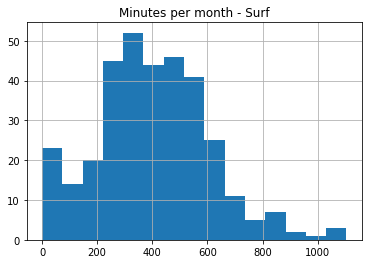

In [39]:
surf_slice['mins_per_month'].hist(bins=15)
#plots a histogram with 15 bins for the mins_per_month column

plt.title('Minutes per month - Surf')
#titles the histogram: Minutes per month -Surf

plt.show() #shows the histogram

We can see that most of the surf plan users call between 200 and 650 with a peak near 350. A general decrease can be observed on each side of the range. Since the mean is greater than the median, we can observe that the histogram has a positive skew (or a skew to the right)

#### Data Volume analysis

Let us do the same for the amount of data used i.e the 'gb_used' column. Same drill; we find the variance...

In [40]:
np.var(surf_slice['gb_per_month'])

204.71067969266684

...then the mean and standard deviation using describe()

In [41]:
surf_slice['gb_per_month'].describe()

count    339.000000
mean      37.950576
std       14.328864
min        0.000000
25%       31.645833
50%       39.500000
75%       47.000000
max       83.500000
Name: gb_per_month, dtype: float64

...then we plot a histogram.

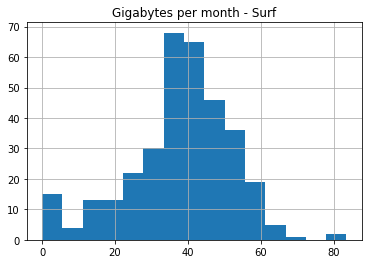

In [42]:
surf_slice['gb_per_month'].hist(bins=15)
plt.title('Gigabytes per month - Surf')
plt.show()

We observe a peak near 35GB per month with typical usage ranging from around 30GB to about 50GB. We can observe an outlier in the histogram, letting us know that 2 or 3 people use around 80GB monthly. There is no big difference between the mean and median so the histogram looks like it has no skew. However, if you take away the outliers (i.e around 80GB), we will observe a more negative skew

#### Messages per month analysis

Same for the messages per month. Variance:

In [43]:
np.var(surf_slice['messages_per_month'])

961.4700042499394

Mean and standard deviation:

In [44]:
surf_slice['messages_per_month'].describe()

count    339.000000
mean      31.967547
std       31.053415
min        0.000000
25%        5.166667
50%       26.500000
75%       49.250000
max      159.000000
Name: messages_per_month, dtype: float64

We now plot the histogram

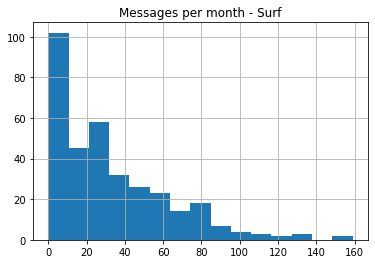

In [45]:
surf_slice['messages_per_month'].hist(bins=15)
plt.title('Messages per month - Surf')
plt.show()

We observe a steady decrease, with the peak ranging from 0 to about 10 messages in a month. So more people text less and less people text more.

### Analyzing the behavior of 'ultimate' users

Now let us create our slice for the ultimate plan

In [46]:
ultimate_slice = user_stats.query('plan == "ultimate"')
#creates a slice of the user_stats table where the plan column value is 'ultimate'

ultimate_slice.info(verbose=True) #general info about the slice

<class 'pandas.core.frame.DataFrame'>
Int64Index: 161 entries, 0 to 497
Data columns (total 11 columns):
user_id               161 non-null int64
first_name            161 non-null object
last_name             161 non-null object
city                  161 non-null object
plan                  161 non-null category
calls_per_month       161 non-null float64
mins_per_month        161 non-null float64
messages_per_month    161 non-null float64
gb_per_month          161 non-null float64
monthly_profit        161 non-null float64
region                161 non-null category
dtypes: category(2), float64(5), int64(1), object(3)
memory usage: 13.1+ KB


#### Minutes per month analysis

Starting with 'mins_per_month', same drill again. Variance:

In [47]:
np.var(ultimate_slice['mins_per_month'])

42639.21197583834

Mean and standard deviation using describe():

In [48]:
ultimate_slice['mins_per_month'].describe()

count     161.000000
mean      399.210867
std       207.136928
min         0.000000
25%       261.000000
50%       414.000000
75%       511.500000
max      1054.571429
Name: mins_per_month, dtype: float64

Let us now plot the histogram

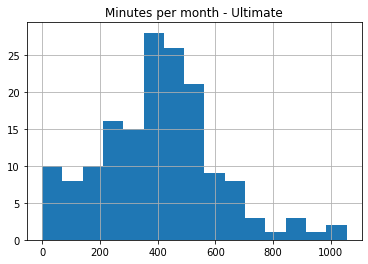

In [49]:
ultimate_slice['mins_per_month'].hist(bins=15)
plt.title('Minutes per month - Ultimate')
plt.show()

Most of the users spend between 200 and about 550 minutes a month. We can safely say from the histogram that over 750 is outlier territory and their outlier territory is more populated than that of the surf users. Remove the outliers and we can observe a more negative skew.

#### Data Volume analysis

Same drill for the amount of data i.e 'gb_per_month'. Let's get the variance:

In [50]:
np.var(ultimate_slice['gb_per_month'])

187.49927830187832

Let us get the mean and standard deviation using describe():

In [51]:
ultimate_slice['gb_per_month'].describe()

count    161.000000
mean      37.956418
std       13.735762
min        0.000000
25%       31.333333
50%       39.625000
75%       47.083333
max       69.000000
Name: gb_per_month, dtype: float64

And now, the histogram

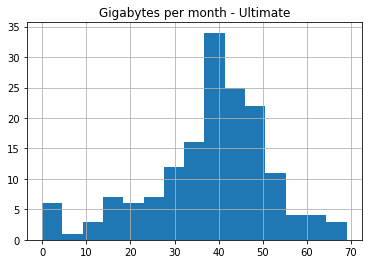

In [52]:
ultimate_slice['gb_per_month'].hist(bins=15)
plt.title('Gigabytes per month - Ultimate')
plt.show()

We observe a peak around 40GB (higher than surf), with the typical amount ranging from around 30 to about 50. A negative skew on the graph is observed

#### Messages per month analysis

'messages_per_month' column; variance:

In [53]:
np.var(ultimate_slice['messages_per_month'])

1083.8189743709763

The mean and standard deviation using describe():

In [54]:
ultimate_slice['messages_per_month'].describe()

count    161.000000
mean      37.554779
std       33.024125
min        0.000000
25%        9.000000
50%       32.142857
75%       60.000000
max      148.000000
Name: messages_per_month, dtype: float64

And the histogram:

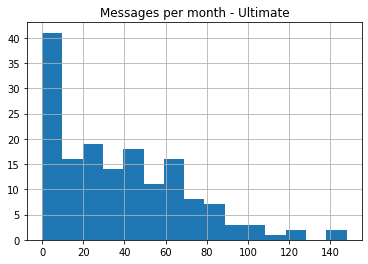

In [55]:
ultimate_slice['messages_per_month'].hist(bins=15)
plt.title('Messages per month - Ultimate')
plt.show()

We observe a generally steady decrease, the peak being from 0 to 10 messages. It is a noisier histogram than its surf counterpart and outlier can be observed around 140 messages

- **Conclusion**

We have analyzed the behavior of users for both plans. For surf, We can see that most of the surf plan users call between 200 and 650 minutes, with typical data usage ranging from around 30GB to about 50GB, most of them sending 0 to about 10 messages in a month. For ultimate, most of the users spend between 200 and about 550 minutes a month, with the typical data usage ranging from around 30 to about 50GB, most of them sending 0 to about 10 messages in a month.

## Hypothesis Testing <a name='step4'></a>

### Hypothesis Test 1: "The average profit from users of Ultimate and Surf calling plans differs"

We need to first of all specify that our null hypothesis is: "The average profit from users of Ultimate and Surf calling plans differs". Therefore, our alternate hypothesis will be the oppositeof the null hypothesis, so it will be: "The average profit from users of Ultimate and Surf calling plans are the same". We will use the "st.ttest_ind()" method, which is used as a t-test for equality of means or averages between 2 statistical populations. The function returns a p-value which we will compare to a value we will set for ourselves known as statistical significance (we will call it alpha and set it at 5%). Our alpha acts as a threshold; if our p-value is less than our alpha, that tells us that the averages (means) are not likely the same which will in this case, give us grounds to NOT reject the hypothesis. If it turns out to be greater than our alpha, that tells us that the averages (means) are likely to be the same, which in this case gives us grounds to reject the null hypothesis. First of all, we need to to check whether the variances of both datasets are different or the same (at least approximately the same). We will be looking at the 'monthly_profit' columns from the 'surf_slice' and 'ultimate_slice' tables we created earlier. Let us get the variance of ultimate_slice['monthly_profit']

In [56]:
np.var(ultimate_slice['monthly_profit'])

4153.420934329156

Now for surf_slice['monthly_profit']

In [57]:
np.var(surf_slice['monthly_profit'])

16204.426970339924

The variances are quite far from each other. We can conduct our test

In [58]:
alpha = 0.05 #setting our statistical significance at 5%

results = st.ttest_ind(ultimate_slice['monthly_profit'], surf_slice['monthly_profit'], equal_var=False)
#performing the test on the monthly_profit columns of both slices specifying that their variances are not
#equal

print('p-value:', results.pvalue) #prints out the p-value from the test

#conditional statement
if results.pvalue < alpha:
#if the p-value is less than alpha meaning the averages are not the same
    print('We cannot ignore the null hypothesis')
else:
#if not
    print('We reject the null hypothesis')

p-value: 5.09742522452306e-61
We cannot ignore the null hypothesis


The p-value is a lot lesser than alpha, which means that the averages of both sets are not likely to be equal. So we don't we don't have the grounds to reject the null hypothesis

### Hypothesis Test 2: "The average profit from users in NY-NJ area is different from that of the users from other regions"

We will first need to create the slice where the 'region' column = "ny-nj" and another where the 'region' = "other"

In [59]:
nynj_slice = user_stats.query('region == "ny-nj"')
nynj_slice.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 80 entries, 14 to 498
Data columns (total 11 columns):
user_id               80 non-null int64
first_name            80 non-null object
last_name             80 non-null object
city                  80 non-null object
plan                  80 non-null category
calls_per_month       80 non-null float64
mins_per_month        80 non-null float64
messages_per_month    80 non-null float64
gb_per_month          80 non-null float64
monthly_profit        80 non-null float64
region                80 non-null category
dtypes: category(2), float64(5), int64(1), object(3)
memory usage: 6.6+ KB


In [60]:
other_area_slice = user_stats.query('region == "other"')
other_area_slice.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 420 entries, 0 to 499
Data columns (total 11 columns):
user_id               420 non-null int64
first_name            420 non-null object
last_name             420 non-null object
city                  420 non-null object
plan                  420 non-null category
calls_per_month       420 non-null float64
mins_per_month        420 non-null float64
messages_per_month    420 non-null float64
gb_per_month          420 non-null float64
monthly_profit        420 non-null float64
region                420 non-null category
dtypes: category(2), float64(5), int64(1), object(3)
memory usage: 33.8+ KB


So our null hypothesis is: "The average profit from users in NY-NJ area is different from that of the users from other regions". Therefore, our alternate hypothesis is: "The average profit from users in NY-NJ area is the same as that of the users from other regions". It will be the same test; if the p-value is less than our alpha of 0.05, this means the averages (means) of both sets are not likely to be equal, which in this case  gives us grounds to NOT reject the null hypothesis, and vice versa. Let us find their respective variances

In [61]:
np.var(nynj_slice['monthly_profit'])

17342.60590437345

In [62]:
np.var(other_area_slice['monthly_profit'])

18284.03346112292

The variances are far apart. Let us test.

In [63]:
alpha = 0.05
results = st.ttest_ind(nynj_slice['monthly_profit'], other_area_slice['monthly_profit'], equal_var=False)
print('p-value:', results.pvalue)
if results.pvalue < alpha:
    print('We cannot ignore the null hypothesis')
else:
    print('We reject the null hypothesis')

p-value: 0.34256642720484287
We reject the null hypothesis


The p-value is higher than alpha, which means that the averages are more likely to be the same, disproving the null hypothesis

## Overall Conclusion <a nmae='step5'></a>

We analyzed the minutes per month, messages per month, and data volume per month of the users for both surf and ultimate plans, and they have similar behavior. We performed 2 t-tests and we didn't find any grounds to reject the hypothesis that the average profit from users of Ultimate and Surf calling plans differs, but we could reject that which stipulated that the average profit from users in NY-NJ area is different from that of the users from other regions